# Yeast Classification Analysis: Budded vs Unbudded

This notebook analyzes yeast microscopy data to classify cells as budded or unbudded based on morphological features.

## Objectives:
1. Explore the dataset and understand feature distributions
2. Train decision trees to find optimal classification thresholds
3. Compare multiple machine learning models
4. Identify which morphological parameters best predict budding state
5. Extract interpretable decision rules

## 1. Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## 2. Load and Explore Dataset

**📝 Action Required:** Update the `csv_file` path below to point to your dataset.

In [2]:
# ⚠️ UPDATE THIS PATH TO YOUR CSV FILE
csv_file = '../input/20250722-FM-training-set.csv'

# Load the dataset
try:
    df = pd.read_csv(csv_file)
    print(f"✅ Successfully loaded dataset with shape: {df.shape}")
    print(f"\nColumn names: {list(df.columns)}")
except FileNotFoundError:
    print(f"❌ File not found: {csv_file}")
    print("Please update the csv_file path in the cell above")
except Exception as e:
    print(f"❌ Error loading file: {e}")

✅ Successfully loaded dataset with shape: (1345, 12)

Column names: ['Image', 'Cell', 'Area', 'Perimeter', 'Major_diameter', 'Minor_diameter', 'Angle', 'Circularity', 'Aspect_ratio', 'Round', 'Solidity', 'Budded']


In [3]:
# Display basic information about the dataset
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"\nData types:")
print(df.dtypes)
print(f"\nFirst 5 rows:")
df.head()

Dataset Overview:
Shape: (1345, 12)

Data types:
Image               int64
Cell                int64
Area              float64
Perimeter         float64
Major_diameter    float64
Minor_diameter    float64
Angle             float64
Circularity       float64
Aspect_ratio      float64
Round             float64
Solidity          float64
Budded               bool
dtype: object

First 5 rows:


Image  Cell    Area  Perimeter  Major_diameter  Minor_diameter    Angle  \
0      1     1   6.291      9.453           3.035           2.640   34.610   
1      2     1  10.490     11.971           3.703           3.608  141.480   
2      3     1   5.226      8.588           2.818           2.361  143.708   
3      3     2   7.622     10.433           3.459           2.805  141.711   
4      4     1   5.644      8.848           2.737           2.625   28.098   

   Circularity  Aspect_ratio  Round  Solidity  Budded  
0        0.885         1.150  0.870     0.964   False  
1        0.920         1.026  0.974     0.976   False  
2        0.890         1.193  0.838     0.965   False  
3        0.880         1.233  0.811     0.965   False  
4        0.906         1.043  0.959     0.961   False

In [4]:
# Check for missing values and basic statistics
print("Missing values:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
df.describe()

Missing values:
Image             0
Cell              0
Area              0
Perimeter         0
Major_diameter    0
Minor_diameter    0
Angle             0
Circularity       0
Aspect_ratio      0
Round             0
Solidity          0
Budded            0
dtype: int64

Basic statistics:


Image         Cell         Area    Perimeter  Major_diameter  \
count  1345.000000  1345.000000  1345.000000  1345.000000     1345.000000   
mean     16.054275     4.010409    10.549737    13.052709        4.526594   
std       8.394879     3.096159     3.965186     3.475790        1.378268   
min       1.000000     1.000000     4.056000     7.463000        2.311000   
25%       9.000000     2.000000     7.736000    10.639000        3.628000   
50%      16.000000     3.000000     9.705000    12.088000        4.154000   
75%      23.000000     5.000000    12.434000    14.428000        4.899000   
max      30.000000    16.000000    34.188000    27.553000       10.122000   

       Minor_diameter        Angle  Circularity  Aspect_ratio        Round  \
count     1345.000000  1345.000000  1345.000000   1345.000000  1345.000000   
mean         2.930560    89.593296     0.790371      1.564265     0.687407   
std          0.464984    51.134872     0.136230      0.486005     0.161510   
min          1.501000     0.308000     0.403000      1.010000     0.306000   
25%          2.621000    46.222000     0.702000      1.242000     0.591000   
50%          2.907000    88.078000     0.860000      1.381000     0.724000   
75%          3.236000   133.870000     0.890000      1.692000     0.805000   
max          4.765000   179.992000     0.932000      3.264000     0.990000   

         Solidity  
count  1345.00000  
mean      0.94172  
std       0.04433  
min       0.71700  
25%       0.91800  
50%       0.96600  
75%       0.97100  
max       0.98000

## 3. Configure Target Variable and Features

**📝 Action Required:** Update the column names below to match your dataset.

In [5]:
# ⚠️ UPDATE THESE COLUMN NAMES TO MATCH YOUR CSV
target_col = 'Budded'  # Column containing budded/unbudded labels
feature_cols = ['Circularity', 'Perimeter', 'Area', 'Aspect_ratio', 'Major_diameter', 'Minor_diameter', 'Angle', 'Round', 'Solidity']  # Morphological features

# Check if columns exist
missing_cols = [col for col in [target_col] + feature_cols if col not in df.columns]
if missing_cols:
    print(f"❌ Missing columns: {missing_cols}")
    print(f"Available columns: {list(df.columns)}")
    print("Please update the column names above")
else:
    print("✅ All required columns found")
    
    # Show target variable distribution
    print(f"\nTarget variable '{target_col}' distribution:")
    print(df[target_col].value_counts())
    print(f"\nClass proportions:")
    print(df[target_col].value_counts(normalize=True).round(3))

✅ All required columns found

Target variable 'Budded' distribution:
Budded
False    953
True     392
Name: count, dtype: int64

Class proportions:
Budded
False    0.709
True     0.291
Name: proportion, dtype: float64


## 4. Data Visualization and Exploration


Circularity statistics by Budded:
         mean    std
Budded              
False   0.870  0.037
True    0.597  0.088

Perimeter statistics by Budded:
          mean    std
Budded               
False   11.329  1.573
True    17.244  3.262

Area statistics by Budded:
          mean    std
Budded               
False    9.044  2.499
True    14.210  4.459

Aspect_ratio statistics by Budded:
         mean    std
Budded              
False   1.339  0.186
True    2.113  0.549


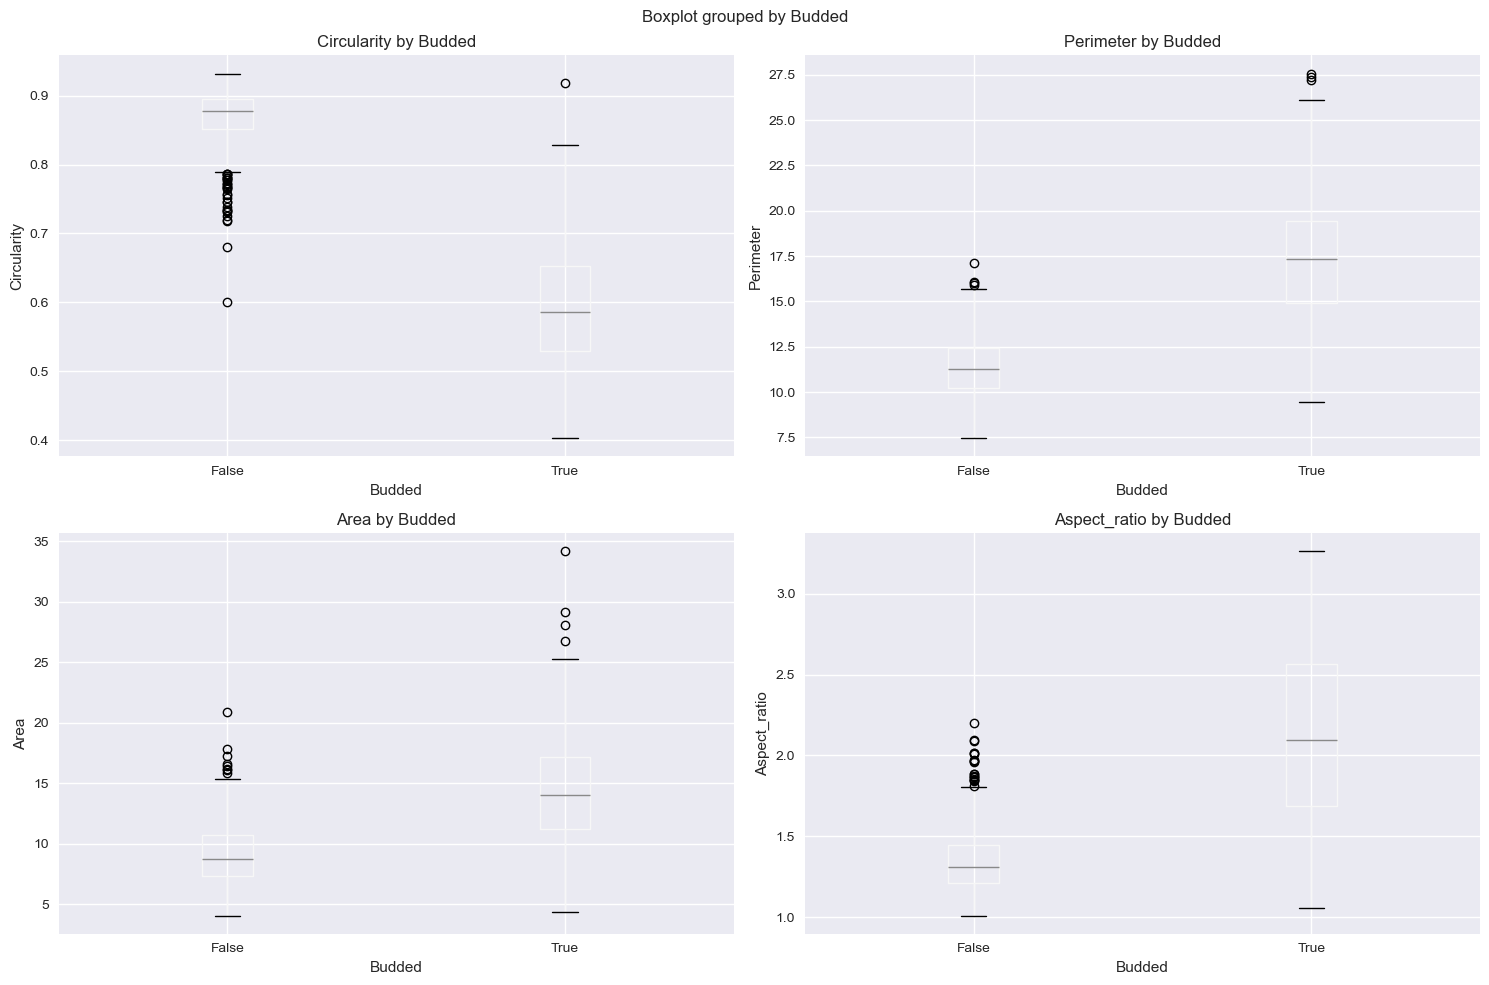

In [6]:
# Create visualizations to understand feature distributions by class
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(feature_cols):
    if i < len(axes):
        # Box plot showing feature distribution by class
        df.boxplot(column=feature, by=target_col, ax=axes[i])
        axes[i].set_title(f'{feature} by {target_col}')
        axes[i].set_xlabel(target_col)
        axes[i].set_ylabel(feature)
        
        # Calculate and display basic statistics by group
        stats = df.groupby(target_col)[feature].agg(['mean', 'std']).round(3)
        print(f"\n{feature} statistics by {target_col}:")
        print(stats)

plt.tight_layout()
plt.show()

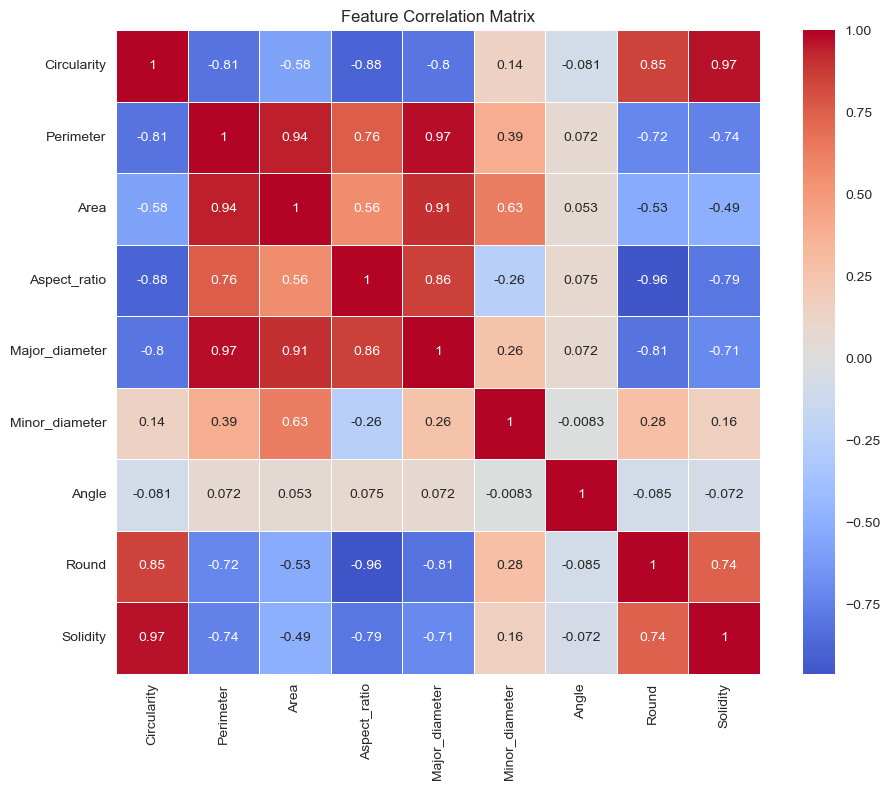

Correlation insights:
Highly correlated feature pairs (|r| > 0.7):
  Circularity ↔ Perimeter: r = -0.807
  Circularity ↔ Aspect_ratio: r = -0.876
  Circularity ↔ Major_diameter: r = -0.800
  Circularity ↔ Round: r = 0.853
  Circularity ↔ Solidity: r = 0.967
  Perimeter ↔ Area: r = 0.942
  Perimeter ↔ Aspect_ratio: r = 0.761
  Perimeter ↔ Major_diameter: r = 0.973
  Perimeter ↔ Round: r = -0.716
  Perimeter ↔ Solidity: r = -0.739
  Area ↔ Major_diameter: r = 0.906
  Aspect_ratio ↔ Major_diameter: r = 0.855
  Aspect_ratio ↔ Round: r = -0.960
  Aspect_ratio ↔ Solidity: r = -0.793
  Major_diameter ↔ Round: r = -0.814
  Major_diameter ↔ Solidity: r = -0.707
  Round ↔ Solidity: r = 0.744


In [7]:
# Correlation analysis
plt.figure(figsize=(10, 8))
correlation_matrix = df[feature_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("Correlation insights:")
# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((feature_cols[i], feature_cols[j], corr_val))

if high_corr_pairs:
    print("Highly correlated feature pairs (|r| > 0.7):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} ↔ {feat2}: r = {corr:.3f}")
else:
    print("No highly correlated features found (all |r| ≤ 0.7)")

<Figure size 1200x1000 with 0 Axes>

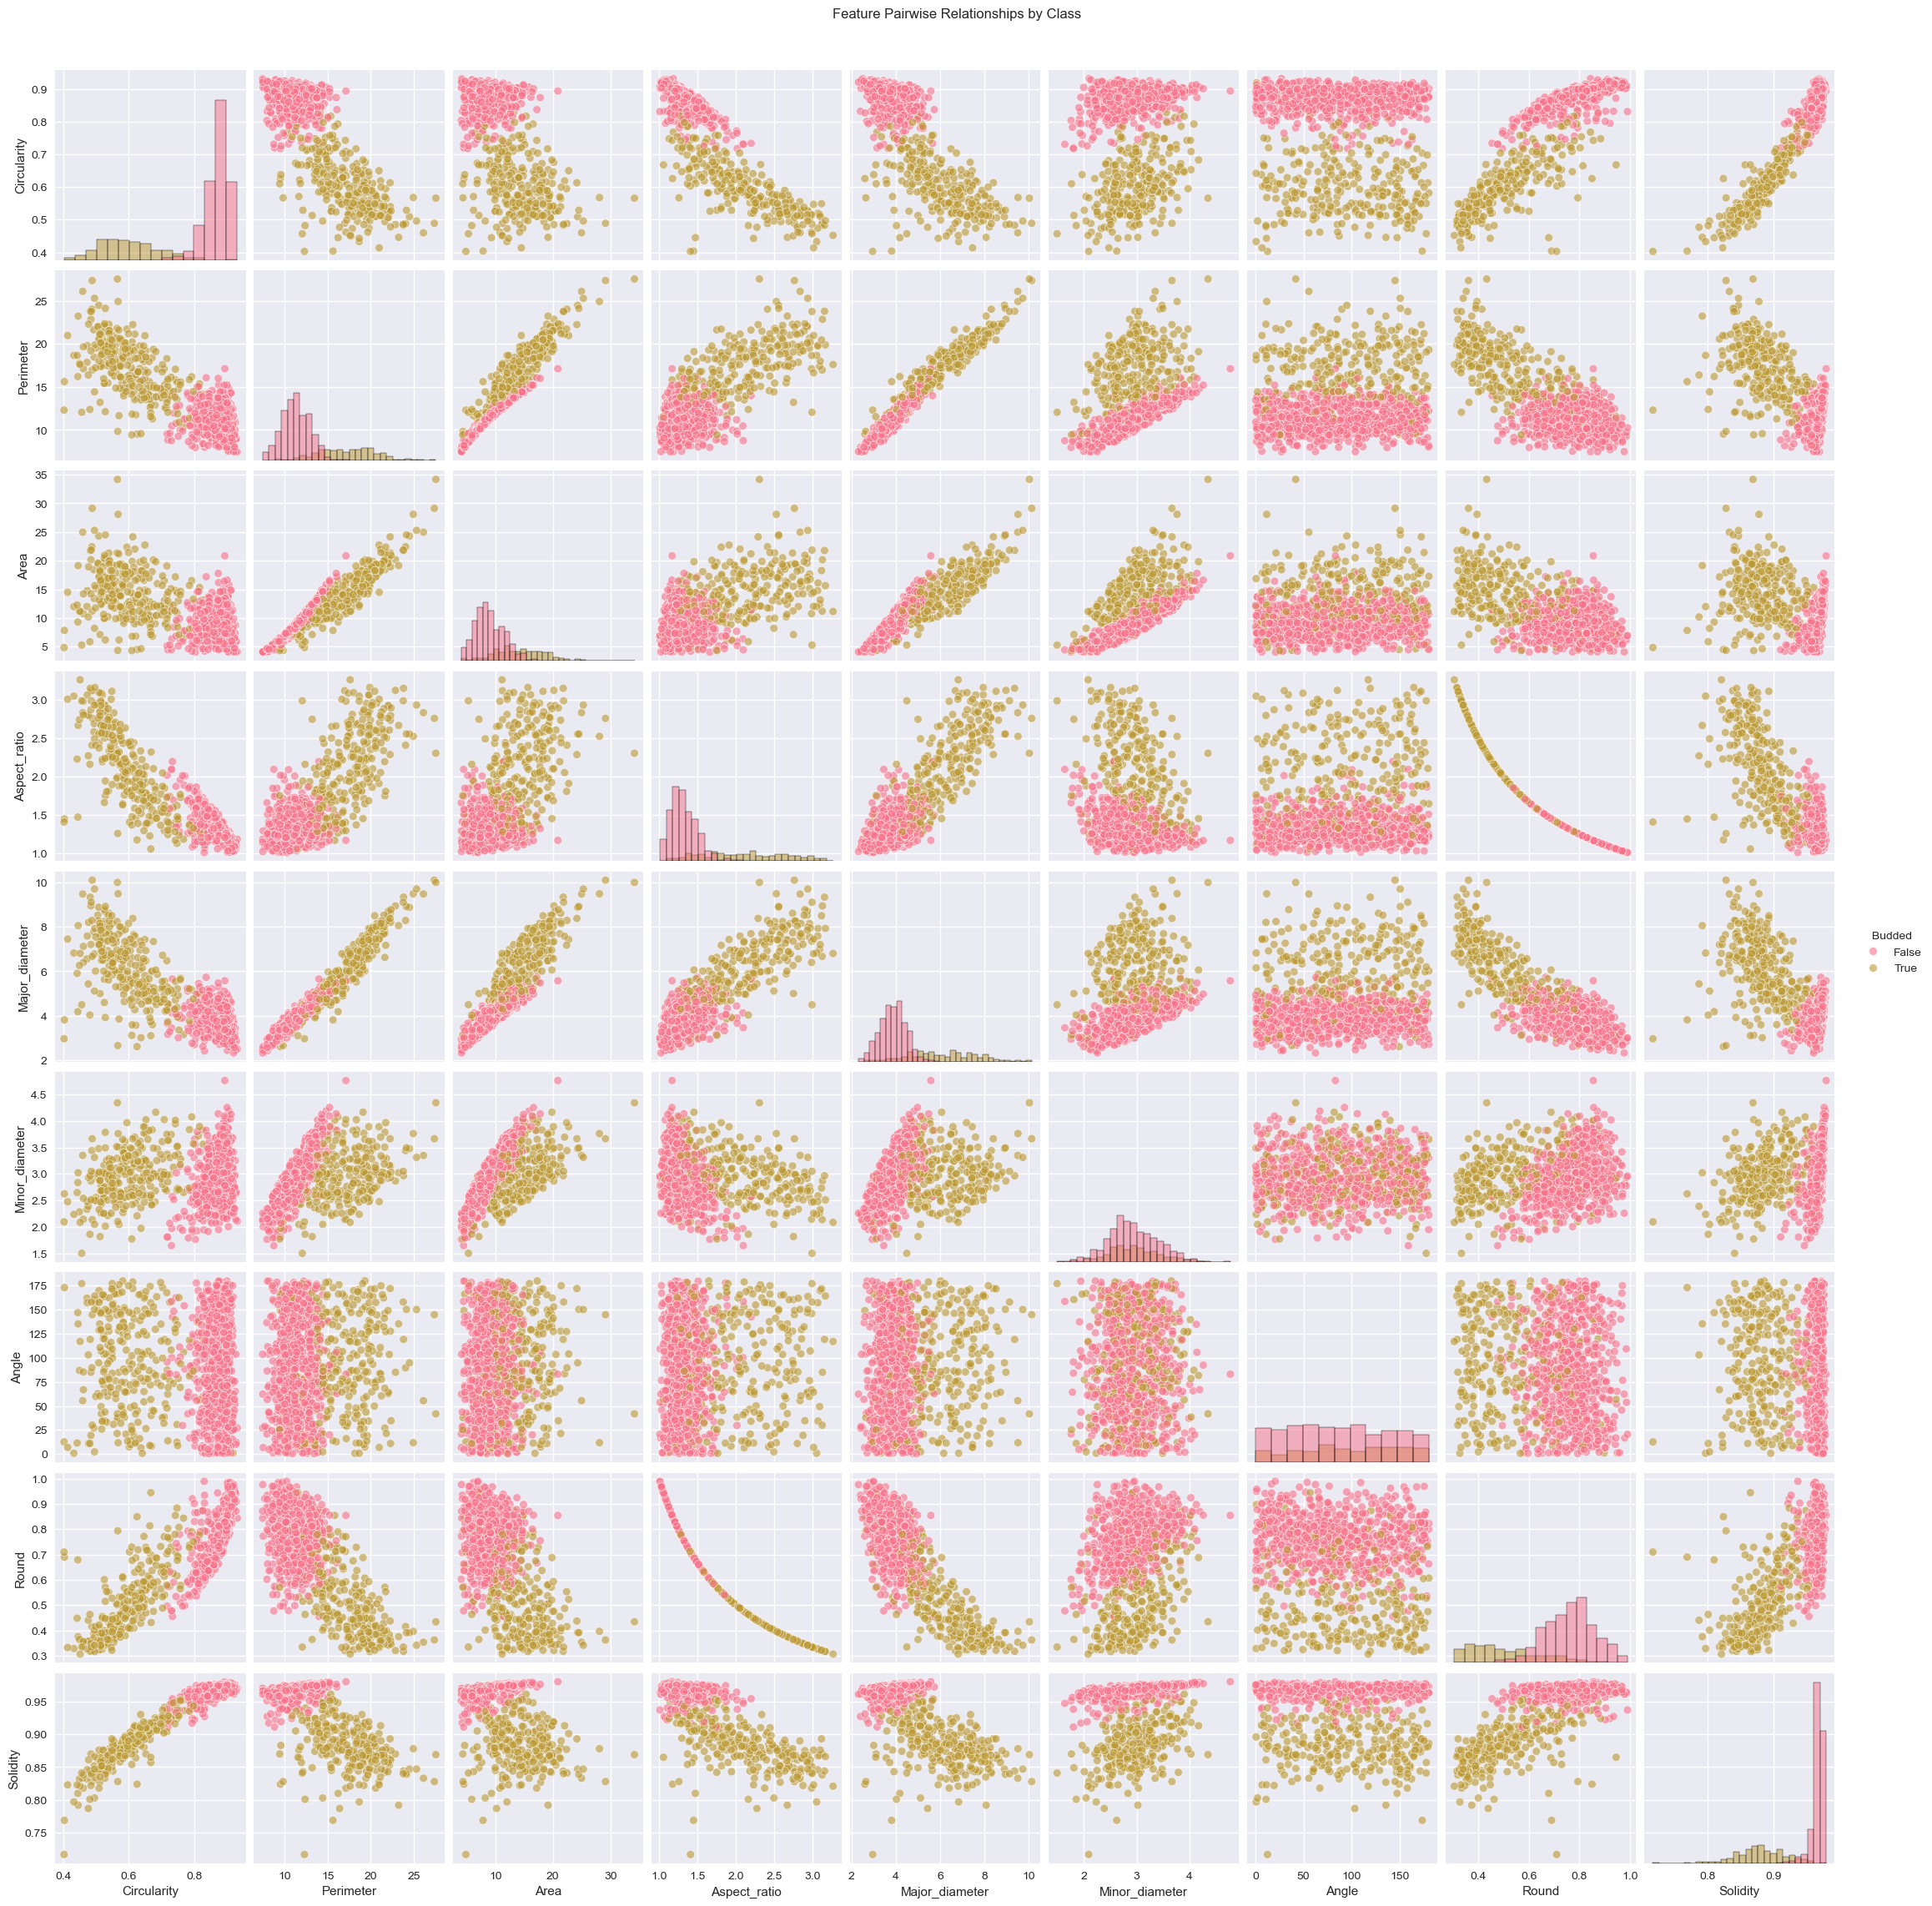

In [8]:
# Pairwise scatter plots to visualize feature relationships
# Create a subset for visualization if dataset is large
df_sample = df.sample(min(1000, len(df)), random_state=42) if len(df) > 1000 else df

# Create pairplot
plt.figure(figsize=(12, 10))
pairplot = sns.pairplot(df_sample[feature_cols + [target_col]], 
                       hue=target_col, diag_kind='hist', 
                       plot_kws={'alpha': 0.6})
pairplot.fig.suptitle('Feature Pairwise Relationships by Class', y=1.02)
plt.show()

## 5. Data Preparation

In [9]:
# Prepare features and target
X = df[feature_cols].copy()
y = df[target_col].copy()

# Convert target to binary if it's categorical
if y.dtype == 'object':
    unique_values = y.unique()
    print(f"Target values: {unique_values}")
    
    # Map to binary (adjust mapping as needed)
    if 'budded' in unique_values and 'unbudded' in unique_values:
        y = y.map({'budded': 1, 'unbudded': 0})
        print("Mapped: budded=1, unbudded=0")
    else:
        print("⚠️ Please manually define the mapping for your target values")

print(f"\nFinal target distribution:")
print(f"Class 0 (unbudded): {(y == 0).sum()}")
print(f"Class 1 (budded): {(y == 1).sum()}")
print(f"Balance ratio: {(y == 1).sum() / len(y):.3f}")


Final target distribution:
Class 0 (unbudded): 953
Class 1 (budded): 392
Balance ratio: 0.291


In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {list(X_train.columns)}")

# Check class balance in splits
print(f"\nTraining set class balance: {y_train.mean():.3f}")
print(f"Test set class balance: {y_test.mean():.3f}")

Training set: 1076 samples
Test set: 269 samples
Features: ['Circularity', 'Perimeter', 'Area', 'Aspect_ratio', 'Major_diameter', 'Minor_diameter', 'Angle', 'Round', 'Solidity']

Training set class balance: 0.292
Test set class balance: 0.290


## 6. Decision Tree Analysis

Let's train a decision tree to find optimal thresholds for classification.

In [11]:
# Hyperparameter tuning for decision tree
print("🔍 Tuning Decision Tree hyperparameters...")

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
dt_grid.fit(X_train, y_train)

print(f"✅ Best parameters: {dt_grid.best_params_}")
print(f"✅ Best cross-validation ROC AUC: {dt_grid.best_score_:.3f}")

# Get the best model
best_dt = dt_grid.best_estimator_

🔍 Tuning Decision Tree hyperparameters...
✅ Best parameters: {'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 2}
✅ Best cross-validation ROC AUC: 0.991


📊 Decision Tree Performance:
Test ROC AUC: 0.999

Classification Report:
              precision    recall  f1-score   support

    unbudded       0.98      1.00      0.99       191
      budded       1.00      0.96      0.98        78

    accuracy                           0.99       269
   macro avg       0.99      0.98      0.99       269
weighted avg       0.99      0.99      0.99       269



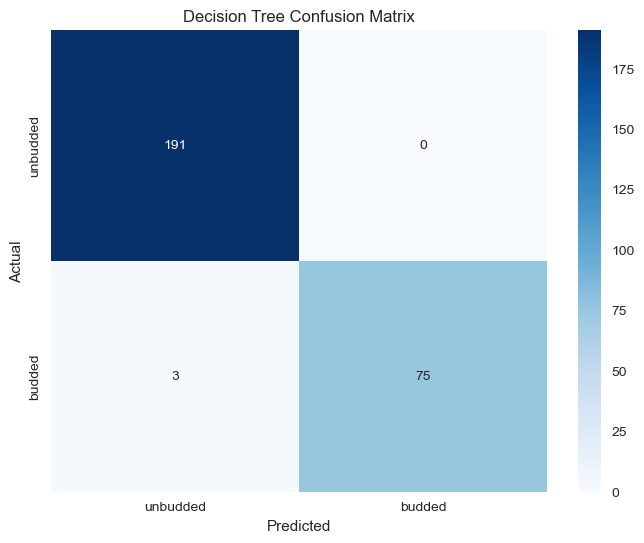

In [12]:
# Evaluate decision tree performance
y_pred_dt = best_dt.predict(X_test)
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]

print("📊 Decision Tree Performance:")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_prob_dt):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['unbudded', 'budded']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['unbudded', 'budded'],
            yticklabels=['unbudded', 'budded'])
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

🎯 Decision Tree Feature Importance:
          feature  importance
0     Circularity    0.943245
8        Solidity    0.024373
2            Area    0.019170
1       Perimeter    0.011643
6           Angle    0.000660
5  Minor_diameter    0.000497
7           Round    0.000410
3    Aspect_ratio    0.000000
4  Major_diameter    0.000000


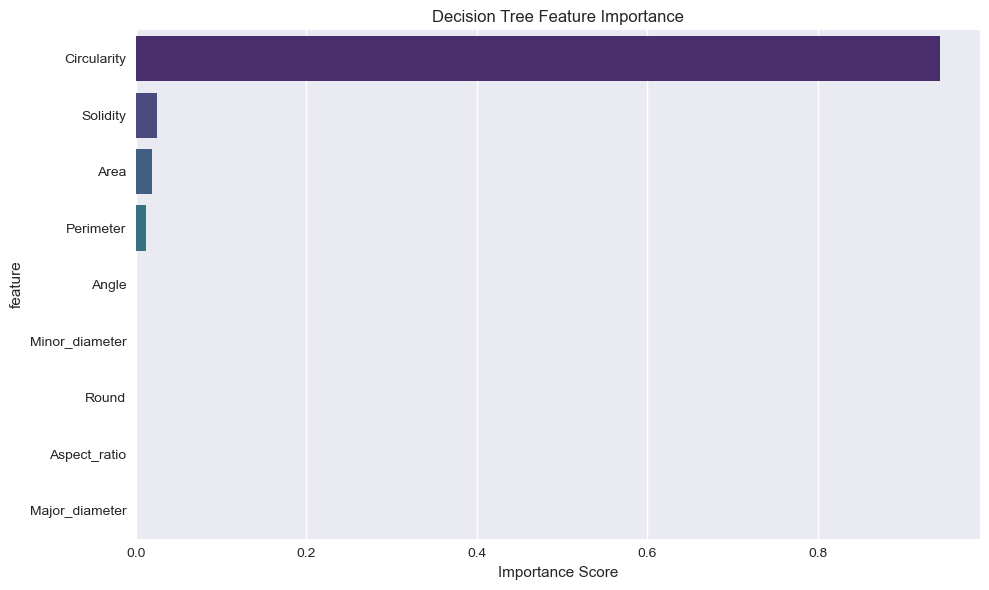

In [13]:
# Feature importance analysis
dt_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

print("🎯 Decision Tree Feature Importance:")
print(dt_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=dt_importance, x='importance', y='feature', palette='viridis')
plt.title('Decision Tree Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

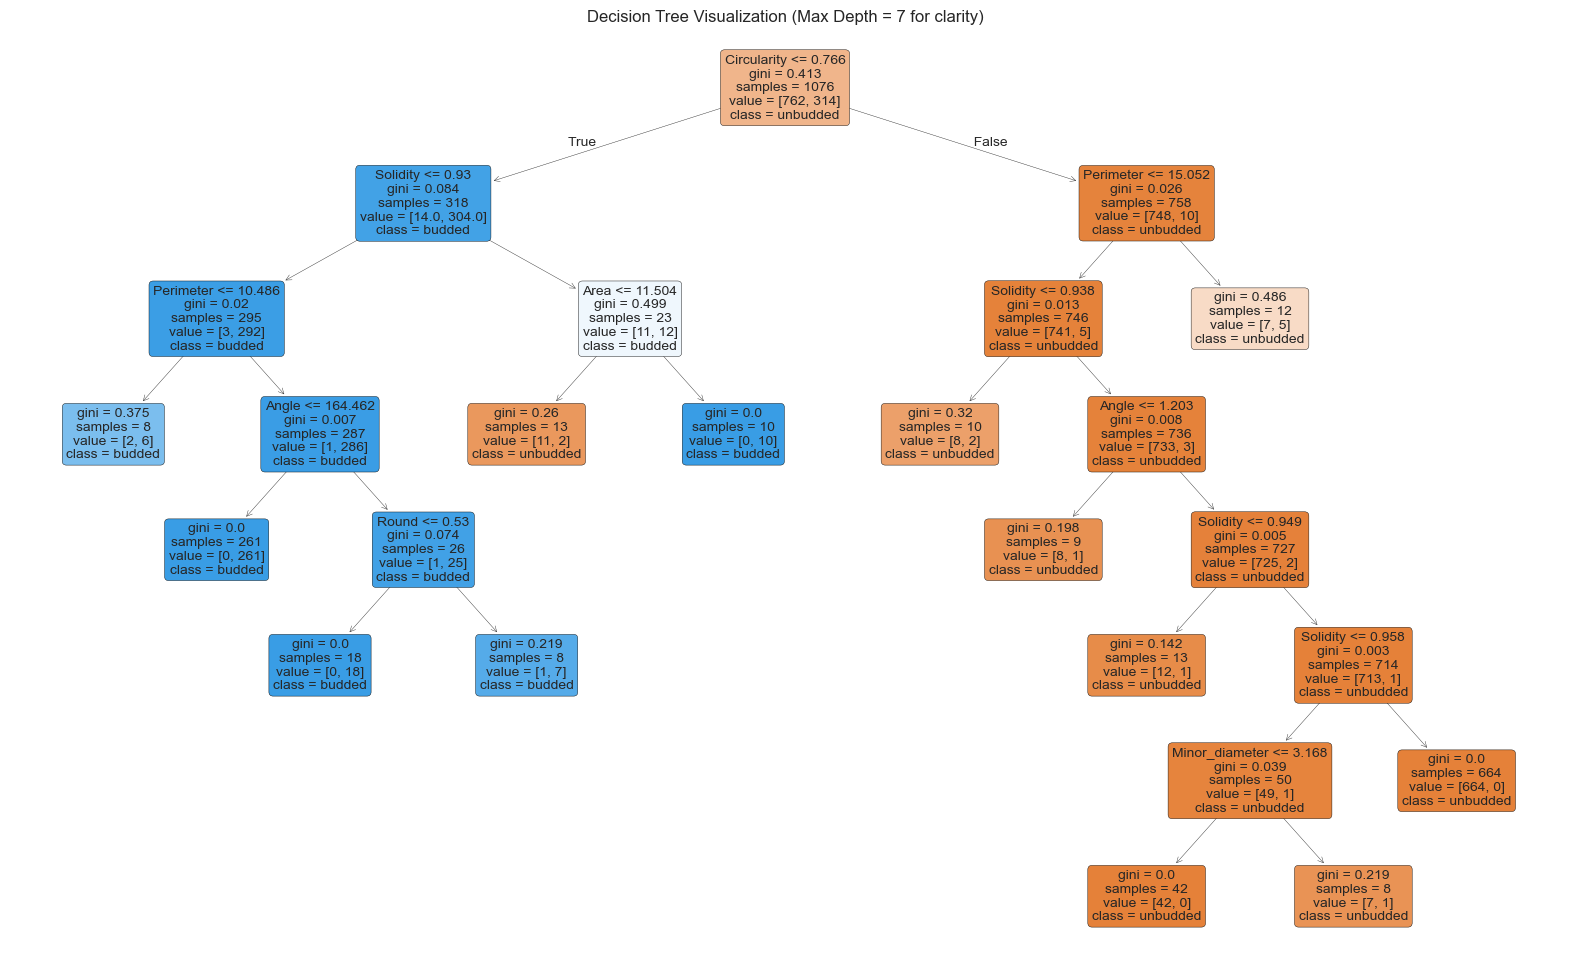

💡 Tree Interpretation:
- Each box shows a decision rule (threshold)
- Orange boxes = majority unbudded, Blue boxes = majority budded
- Follow paths from root to leaves to see classification rules


In [14]:
# Visualize the decision tree
plt.figure(figsize=(20, 12))
plot_tree(best_dt, max_depth=7,  # Limit depth for readability
          feature_names=feature_cols,
          class_names=['unbudded', 'budded'],
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Visualization (Max Depth = 7 for clarity)')
plt.show()

print("💡 Tree Interpretation:")
print("- Each box shows a decision rule (threshold)")
print("- Orange boxes = majority unbudded, Blue boxes = majority budded")
print("- Follow paths from root to leaves to see classification rules")

In [15]:
# Extract decision thresholds from the tree
def extract_tree_thresholds(tree, feature_names):
    """Extract all thresholds used by the decision tree"""
    thresholds = {}
    
    for i in range(tree.tree_.node_count):
        # Check if it's not a leaf node
        if tree.tree_.children_left[i] != tree.tree_.children_right[i]:
            feature_idx = tree.tree_.feature[i]
            feature_name = feature_names[feature_idx]
            threshold = tree.tree_.threshold[i]
            
            if feature_name not in thresholds:
                thresholds[feature_name] = []
            thresholds[feature_name].append(threshold)
    
    # Sort and remove duplicates
    for feature in thresholds:
        thresholds[feature] = sorted(list(set(thresholds[feature])))
    
    return thresholds

thresholds = extract_tree_thresholds(best_dt, feature_cols)

print("🔍 Decision Tree Thresholds:")
print("These are the exact cutoff values used for classification:\n")

for feature, thresh_list in thresholds.items():
    print(f"📐 {feature}:")
    for thresh in thresh_list:
        print(f"    - Threshold: {thresh:.3f}")
    print()

# Show simple decision rules
print("💡 Example Decision Rules:")
print("(These are simplified examples - actual tree may be more complex)")
for feature, thresh_list in thresholds.items():
    if thresh_list:  # If feature has thresholds
        thresh = thresh_list[0]  # Use first threshold as example
        print(f"   If {feature} ≤ {thresh:.3f} → tends toward one class")
        print(f"   If {feature} > {thresh:.3f} → tends toward other class")

🔍 Decision Tree Thresholds:
These are the exact cutoff values used for classification:

📐 Circularity:
    - Threshold: 0.766

📐 Solidity:
    - Threshold: 0.930
    - Threshold: 0.938
    - Threshold: 0.949
    - Threshold: 0.958

📐 Perimeter:
    - Threshold: 10.486
    - Threshold: 15.052

📐 Angle:
    - Threshold: 1.203
    - Threshold: 164.462

📐 Round:
    - Threshold: 0.530

📐 Area:
    - Threshold: 11.504

📐 Minor_diameter:
    - Threshold: 3.168

💡 Example Decision Rules:
(These are simplified examples - actual tree may be more complex)
   If Circularity ≤ 0.766 → tends toward one class
   If Circularity > 0.766 → tends toward other class
   If Solidity ≤ 0.930 → tends toward one class
   If Solidity > 0.930 → tends toward other class
   If Perimeter ≤ 10.486 → tends toward one class
   If Perimeter > 10.486 → tends toward other class
   If Angle ≤ 1.203 → tends toward one class
   If Angle > 1.203 → tends toward other class
   If Round ≤ 0.530 → tends toward one class
   If R

## 7. Random Forest Analysis

Compare with Random Forest for potentially better performance and more robust feature importance.

In [ ]:
# Train Random Forest
print("🌲 Training Random Forest...")

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC AUC: {cv_scores.mean():.3f} (±{cv_scores.std() * 2:.3f})")

# Test performance
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print(f"\n📊 Random Forest Performance:")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_prob_rf):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['unbudded', 'budded']))

In [ ]:
# Random Forest feature importance
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("🎯 Random Forest Feature Importance:")
print(rf_importance)

# Compare feature importance between models
comparison = dt_importance.merge(rf_importance, on='feature', suffixes=('_dt', '_rf'))

plt.figure(figsize=(12, 6))
x = np.arange(len(comparison))
width = 0.35

plt.bar(x - width/2, comparison['importance_dt'], width, 
        label='Decision Tree', alpha=0.8, color='skyblue')
plt.bar(x + width/2, comparison['importance_rf'], width, 
        label='Random Forest', alpha=0.8, color='lightcoral')

plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance Comparison: Decision Tree vs Random Forest')
plt.xticks(x, comparison['feature'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 8. Model Comparison

Compare multiple algorithms to find the best approach for your data.

In [ ]:
# Compare multiple models
print("🏆 Model Comparison")
print("=" * 50)

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42)
}

results = {}

# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Use scaled features for SVM and Logistic Regression
    if name in ['SVM', 'Logistic Regression']:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train.values, X_test.values
    
    # Train model
    model.fit(X_tr, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='roc_auc')
    
    # Test prediction
    y_prob = model.predict_proba(X_te)[:, 1]
    test_auc = roc_auc_score(y_test, y_prob)
    
    results[name] = {
        'CV_AUC_mean': cv_scores.mean(),
        'CV_AUC_std': cv_scores.std(),
        'Test_AUC': test_auc
    }
    
    print(f"  CV ROC AUC: {cv_scores.mean():.3f} (±{cv_scores.std() * 2:.3f})")
    print(f"  Test ROC AUC: {test_auc:.3f}")

print("\n" + "=" * 50)

In [ ]:
# Visualize model comparison
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('Test_AUC', ascending=False)

plt.figure(figsize=(12, 6))

# Plot CV scores with error bars
plt.errorbar(results_df.index, results_df['CV_AUC_mean'], 
             yerr=results_df['CV_AUC_std'] * 2, 
             marker='o', capsize=5, label='Cross-Validation AUC', alpha=0.7)

# Plot test scores
plt.plot(results_df.index, results_df['Test_AUC'], 
         marker='s', linestyle='--', label='Test AUC', alpha=0.8)

plt.title('Model Performance Comparison')
plt.ylabel('ROC AUC Score')
plt.xlabel('Model')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 Final Model Rankings (by Test AUC):")
for i, (model_name, row) in enumerate(results_df.iterrows(), 1):
    print(f"{i}. {model_name}: {row['Test_AUC']:.3f}")

## 9. ROC Curve Analysis